# Caso Base



## Modelo Matemático: Problema de Ruteo de Vehículos con Capacidad y Autonomía

### **Conjuntos**

-  V : Conjunto de vehículos.
-  N : Conjunto de todos los nodos (depósitos + municipios).
-  P : Conjunto de depósitos.
-  D : Conjunto de municipios (clientes).

### **Parámetros**

- `Ft`: Tarifa de flete por km (COP/km).
- `Cm`: Costo de mantenimiento por km (COP/km).
- `dist_i,j`: Distancia entre el nodo \( i \) y el nodo \( j \) (km).
- ` Q_v `: Capacidad máxima de carga del vehículo \( v \).
- `Autonomy_v`: Autonomía (capacidad de combustible) del vehículo \( v \).
- `demand_j`: Demanda del municipio \( j \).

### **Variables de Decisión**

 $$ x_{v,i,j} \in {0,1}$$

  - 1 si el vehículo \( v\)  viaja del nodo  \(i\)  al nodo \( j\) , 0 en caso contrario.
$$  q_{v,j} \ge 0 $$

  - Cantidad entregada por el vehículo \( v \) en el municipio \( j \).



### **Función Objetivo**

Minimizar el costo total de transporte y mantenimiento:

$$\min \sum_{v \in V} \sum_{\substack{i \in N \\ j \in N \\ i \ne j}} \left( \text{Ft} \times \text{dist}_{i,j} + \text{Cm} \times \text{dist}_{i,j} \right) \times x_{v,i,j}$$



### **Restricciones**

1. **Visita Única por Cliente:**

Cada cliente debe ser visitado exactamente una vez:

$$
\sum_{v \in V} \sum_{\substack{i \in N \\ i \ne j}} x_{v,i,j} = 1 \quad \forall j \in D
$$



2. **Conservación de Flujo:**

Para cada vehículo y cada nodo (excepto depósitos), la cantidad que entra debe ser igual a la que sale:

$$
\sum_{\substack{i \in N \\ i \ne k}} x_{v,i,k} = \sum_{\substack{j \in N \\ j \ne k}} x_{v,k,j} \quad \forall v \in V, \forall k \in N
$$



3. **Capacidad del Vehículo:**

El total de carga entregada por cada vehículo no puede superar su capacidad:

$$
\sum_{j \in D} q_{v,j} \le Q_v \quad \forall v \in V
$$



4. **Entrega de Demanda Condicionada a Visita:**

La cantidad entregada en un municipio solo puede ser positiva si se visita ese municipio:

$$
q_{v,j} \le \text{demand}_j \times \sum_{\substack{i \in N \\ i \ne j}} x_{v,i,j} \quad \forall v \in V, \forall j \in D
$$



5. **Autonomía del Vehículo:**

La distancia total recorrida por cada vehículo no puede superar su autonomía:

$$
\sum_{\substack{i \in N \\ j \in N \\ i \ne j}} \text{dist}_{i,j} \times x_{v,i,j} \le \text{Autonomy}_v \quad \forall v \in V
$$



6. **Salida desde el Depósito:**

Cada vehículo debe salir exactamente una vez desde el depósito:

$$
\sum_{\substack{i \in P \\ j \in N \\ i \ne j}} x_{v,i,j} = 1 \quad \forall v \in V
$$



7. **Retorno al Depósito:**

Cada vehículo debe regresar exactamente una vez al depósito:

$$
\sum_{\substack{i \in N \\ j \in P \\ i \ne j}} x_{v,i,j} = 1 \quad \forall v \in V
$$



### IMPORTANTE

- La función objetivo minimiza los costos combinados de **transporte** y **mantenimiento**.
- El modelo asegura que todos los clientes son visitados, sin sobrepasar la **capacidad** y la **autonomía** de los vehículos.
- Los vehículos deben formar **circuitos completos** desde y hacia el depósito.


## Notebook ejecutado

In [2]:
%pip install -q amplpy

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\MarianaLozano\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [3]:
from amplpy import AMPL, ampl_notebook
ampl = ampl_notebook(
    modules=["highs", "cbc", "gurobi" ], # pick from over 20 modules including most commercial and open-source solvers
    license_uuid="09f4ede2-4840-4d72-9d94-308ef2f972f7") # your license UUID (e.g., free ampl.com/ce or ampl.com/courses licenses)

Licensed to AMPL Community Edition License for <mariana.lozano.col@gmail.com>.


In [4]:
!apt-get install -y coinor-cbc
!pip install pyomo
!pip install coinor-opt
!pip install amplpy
!pip install pyomo[solvers]
!pip install pandas
!pip install matplotlib


'apt-get' is not recognized as an internal or external command,
operable program or batch file.


ERROR: Could not find a version that satisfies the requirement coinor-opt (from versions: none)
ERROR: No matching distribution found for coinor-opt


In [ ]:
# Install missing packages
%pip install pandas numpy matplotlib amplpy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from amplpy import AMPL

# === 1️⃣ Cargar datos ===
clients_df = pd.read_csv('Datos/clients2.csv')
depots_df = pd.read_csv('Datos/depots2.csv')
vehicles_df = pd.read_csv('Datos/vehicles2.csv')
stations_df = pd.read_csv('Datos/stations2.csv')

# === 2️⃣ Preparar conjuntos ===
D = ['MUN' + str(int(row['LocationID'])).zfill(2) for _, row in clients_df.iterrows()]
P = ['PTO01']
E = ['EST' + str(int(row['EstationID'])).zfill(2) for _, row in stations_df.iterrows()]
V = ['VEH' + str(int(row['VehicleID'])).zfill(2) for _, row in vehicles_df.iterrows()]
N = P + D + E

# === 3️⃣ Coordenadas y distancias ===
def haversine(coord1, coord2):
    R = 6371
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

coords = {}
for _, row in depots_df.iterrows():
    coords['PTO01'] = (row['Latitude'], row['Longitude'])
for _, row in stations_df.iterrows():
    key = 'EST' + str(int(row['EstationID'])).zfill(2)
    coords[key] = (row['Latitude'], row['Longitude'])
bogota_coords = (4.624335, -74.063644)
radius = 3
np.random.seed(42)
for i, client_id in enumerate(D):
    lat_offset = np.random.uniform(-radius, radius)
    lon_offset = np.random.uniform(-radius, radius)
    coords[client_id] = (bogota_coords[0] + lat_offset, bogota_coords[1] + lon_offset)

dist = {}
for i in N:
    for j in N:
        if i != j:
            dist[(i, j)] = haversine(coords[i], coords[j])

# ✅✅✅ NUEVO: Definir la lista must_pass después de calcular distancias

must_pass = []


# 👉 O AUTOMÁTICO: Añadir estaciones cercanas automáticamente
for i in N:
    for j in N:
        if i != j and i not in E and j not in E:
            closest_station = None
            min_distance = float('inf')
            for e in E:
                d_ie = dist.get((i, e), 9999)
                d_ej = dist.get((e, j), 9999)
                if d_ie < 15 or d_ej < 15:  # Estaciones a menos de 15 km
                    if d_ie + d_ej < min_distance:
                        min_distance = d_ie + d_ej
                        closest_station = e
            if closest_station:
                must_pass.append((i, j, closest_station))

print(f"✅ MustPassThrough generado con {len(must_pass)} entradas.")


# === 4️⃣ Escribir archivo .dat para AMPL ===
with open('vrp_data.dat', 'w') as f:
    f.write('set V := {} ;\n'.format(' '.join(V)))
    f.write('set N := {} ;\n'.format(' '.join(N)))
    f.write('set D := {} ;\n'.format(' '.join(D)))
    f.write('set P := {} ;\n'.format(' '.join(P)))
    f.write('set E := {} ;\n'.format(' '.join(E)))

    f.write('param Q :=\n')
    for _, row in vehicles_df.iterrows():
        vid = 'VEH' + str(int(row['VehicleID'])).zfill(2)
        f.write(f'{vid} {row["Capacity"]}\n')
    f.write(';\n')

    f.write('param F_cap :=\n')
    consumo = 0.75  # O el valor que tengas actualizado
    for _, row in vehicles_df.iterrows():
        vid = 'VEH' + str(int(row['VehicleID'])).zfill(2)
        F_cap = row['Range'] * consumo
        f.write(f'{vid} {F_cap}\n')
    f.write(';\n')

    f.write('param demand :=\n')
    for _, row in clients_df.iterrows():
        cid = 'MUN' + str(int(row['LocationID'])).zfill(2)
        f.write(f'{cid} {row["Demand"]}\n')
    f.write(';\n')

    f.write('param fuel_price :=\n')
    for _, row in stations_df.iterrows():
        eid = 'EST' + str(int(row['EstationID'])).zfill(2)
        f.write(f'{eid} {row["FuelCost"]}\n')
    f.write(f'PTO01 13500.0\n')
    for cid in D:
        f.write(f'{cid} 0.0\n')
    f.write(';\n')

    f.write('param dist :=\n')
    for (i, j), value in dist.items():
        f.write(f'{i} {j} {value:.4f}\n')
    f.write(';\n')

    # 🚀 MustPassThrough
    if must_pass:
        f.write('set MustPassThrough :=\n')
        for (i, j, e) in must_pass:
            f.write(f'({i}, {j}, {e})\n')
        f.write(';\n')
    else:
        f.write('set MustPassThrough := ;\n')

    # 🚀 Agregar parámetros escalares
    f.write('\nparam Ft := 5000;\n')
    f.write('param Cm := 700;\n')
    f.write('param consumo := 0.75;\n')

print("✅ Archivo vrp_data.dat creado correctamente!")

# === 5️⃣ Ejecutar AMPL ===
ampl = AMPL()
ampl.read('Datos/vrp_model.mod')
ampl.readData('vrp_data.dat')

ampl.setOption('solver', 'gurobi')
ampl.setOption('gurobi_options', 'TimeLimit=600')  # 600 segundos = 10 minutos
print("🚀 Resolviendo con AMPL + Gurobi (límite de 10 minutos)...")
ampl.solve()


# === 6️⃣ Procesar resultados y generar archivo de verificación ===
# === 6️⃣ Procesar resultados y generar archivo de verificación ===
import csv

print("✅ Costo total global:", ampl.getObjective('TotalCost').value())

z = ampl.getVariable('z')
x = ampl.getVariable('x')
r = ampl.getVariable('r')
u = ampl.getVariable('u')

# 🚀 Cargar precios de estaciones
station_prices = {f"EST{str(int(row['EstationID'])).zfill(2)}": row['FuelCost'] for _, row in stations_df.iterrows()}

with open('verificacion_caso2.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow([
        'VehicleId','LoadCap','FuelCap','RouteSequence','Municipalities','DemandSatisfied',
        'InitLoad','InitFuel','RefuelStops','RefuelAmounts','Distance','Time','FuelCost','TotalCost'
    ])

    for v in ampl.getSet('V'):
        usage = z[v].value()
        if usage > 0.001:
            print(f"\n🛻 Vehículo {v}: Utilizado al {usage*100:.2f}%")

            # 🔗 Recolectar arcos
            arcs = []
            for i in ampl.getSet('N'):
                for j in ampl.getSet('N'):
                    if i != j and x[v, i, j].value() > 0.01:
                        arcs.append((i, j))

            # 🛣️ Reconstruir ruta secuencial
            route = ['PTO01']
            current = 'PTO01'
            visited = set(route)
            while True:
                next_nodes = [j for i, j in arcs if i == current and j not in visited]
                if next_nodes:
                    next_node = next_nodes[0]
                    route.append(next_node)
                    visited.add(next_node)
                    current = next_node
                else:
                    depot_return = [j for i, j in arcs if i == current and j == 'PTO01']
                    if depot_return and 'PTO01' not in route[1:]:
                        route.append('PTO01')
                    break

            print("🛣️ Ruta completa:", ' -> '.join(route))

            # Municipios visitados
            muni_visited = [n for n in route if n.startswith('MUN')]
            demand_satisfied = len(muni_visited)
            init_load = sum(ampl.getParameter('demand')[m] for m in muni_visited)
            load_cap = ampl.getParameter('Q')[v]
            fuel_cap = ampl.getParameter('F_cap')[v]

            # Distancia total
            total_distance = sum(
                dist[(route[idx], route[idx+1])]
                for idx in range(len(route)-1)
                if (route[idx], route[idx+1]) in dist
            )

            # Tiempo
            time = (total_distance / 40) * 60  # minutos

            # Recargas
            refuels = []
            refuel_amts = []
            fuel_cost = 0
            for est in E:
                amount = r[v, est].value()
                if amount > 0.01:
                    refuels.append(est)
                    refuel_amts.append(f"{amount:.0f}")
                    fuel_cost += amount * station_prices.get(est, 0)
                    print(f"⛽ {est}: {amount:.2f} gal x {station_prices[est]:.0f} = {amount*station_prices[est]:.0f}")

            print(f"💰 Costo combustible vehículo {v}: {fuel_cost:.0f}")

            # Costos de distancia del vehículo
            distance_cost = sum(
                (ampl.getParameter('Ft') + ampl.getParameter('Cm')) * dist[(i,j)] * x[v, i, j].value()
                for i, j in dist.keys() if x[v, i, j].value() > 0.01
            )

            total_cost_vehicle = distance_cost + fuel_cost
            print(f"💰 Costo total vehículo {v}: {total_cost_vehicle:.0f}")

            writer.writerow([
                v,
                f"{load_cap:.0f}",
                f"{fuel_cap:.0f}",
                ' -'.join(route),
                '-'.join(muni_visited),
                demand_satisfied,
                f"{init_load:.0f}",
                f"{fuel_cap:.0f}",
                len(refuels),
                '-'.join(refuel_amts) if refuel_amts else '0',
                f"{total_distance:.1f}",
                f"{time:.1f}",
                f"{fuel_cost:.0f}",
                f"{total_cost_vehicle:.0f}"
            ])

print("✅ Archivo de verificación generado correctamente.")





✅ MustPassThrough generado con 28 entradas.
✅ Archivo vrp_data.dat creado correctamente!


You should consider upgrading via the 'c:\Users\MarianaLozano\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


🚀 Resolviendo con AMPL + Gurobi (límite de 10 minutos)...
Gurobi 12.0.1:   lim:time = 600
Gurobi 12.0.1: time limit, feasible solution; objective 42134115.48
7.94075e+06 simplex iterations
453745 branching nodes
absmipgap=2.82625e+07, relmipgap=0.670774
✅ Costo total: 42134115.47810141

🛻 Vehículo VEH01: Utilizado al 100.00%
🛣️ Ruta completa: PTO01 -> EST04 -> MUN02 -> MUN07 -> MUN05 -> MUN14 -> EST01 -> PTO01
⛽ EST01: 0.10 gal x 13500 = 1350
⛽ EST04: 0.10 gal x 15200 = 1520
💰 Total combustible vehículo VEH01: 2870

🛻 Vehículo VEH02: Utilizado al 100.00%
🛣️ Ruta completa: PTO01 -> EST09 -> MUN09 -> MUN04 -> MUN12 -> MUN08 -> EST01 -> PTO01
⛽ EST01: 0.10 gal x 13500 = 1350
⛽ EST09: 0.10 gal x 16200 = 1620
💰 Total combustible vehículo VEH02: 2970

🛻 Vehículo VEH03: Utilizado al 100.00%
🛣️ Ruta completa: PTO01 -> EST01 -> MUN03 -> MUN06 -> EST12 -> PTO01
⛽ EST01: 0.10 gal x 13500 = 1350
⛽ EST12: 0.10 gal x 14900 = 1490
💰 Total combustible vehículo VEH03: 2840

🛻 Vehículo VEH04: Utilizado 

C:\Users\MarianaLozano\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


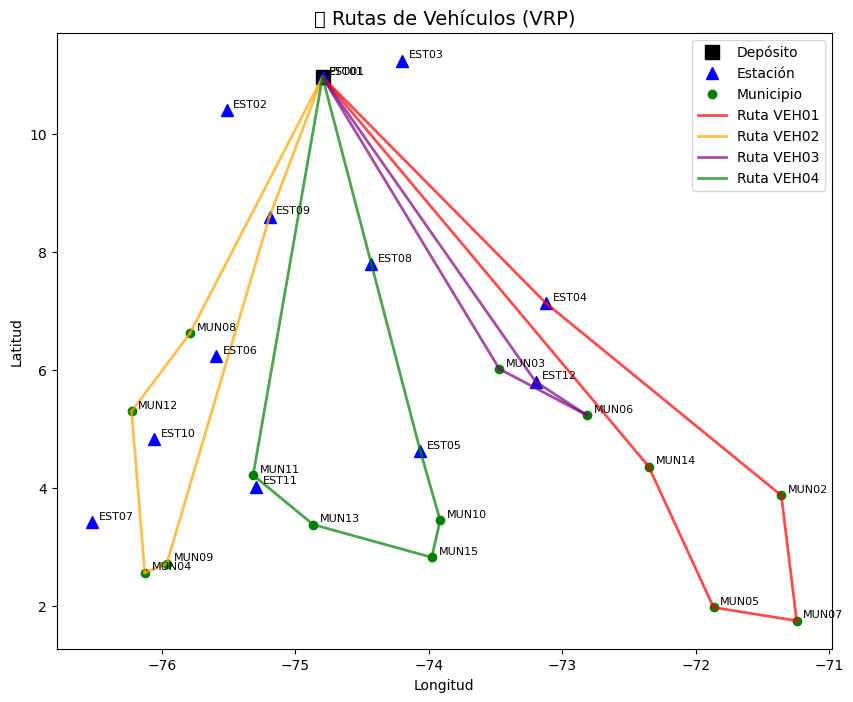

In [7]:
import matplotlib.pyplot as plt

# === Crear el gráfico ===
fig, ax = plt.subplots(figsize=(10, 8))

# 📍 Dibujar todos los nodos
for node, (lat, lon) in coords.items():
    if node.startswith('PTO'):
        ax.plot(lon, lat, 'ks', markersize=10, label='Depósito' if 'Depósito' not in ax.get_legend_handles_labels()[1] else "")
    elif node.startswith('EST'):
        ax.plot(lon, lat, 'b^', markersize=8, label='Estación' if 'Estación' not in ax.get_legend_handles_labels()[1] else "")
    else:
        ax.plot(lon, lat, 'go', markersize=6, label='Municipio' if 'Municipio' not in ax.get_legend_handles_labels()[1] else "")

# ✏️ Dibujar rutas/arcos para cada vehículo
colors = ['red', 'orange', 'purple', 'green', 'cyan', 'magenta']  # Añade más si tienes más vehículos

for idx, v in enumerate(ampl.getSet('V')):
    arcs = []
    for i in ampl.getSet('N'):
        for j in ampl.getSet('N'):
            if i != j:
                flow = x[v, i, j].value()
                if flow > 0.01:
                    arcs.append((i, j))
    # Dibujar los arcos
    for (i, j) in arcs:
        lat_i, lon_i = coords[i]
        lat_j, lon_j = coords[j]
        ax.plot([lon_i, lon_j], [lat_i, lat_j], color=colors[idx % len(colors)],
                linewidth=2, alpha=0.7,
                label=f'Ruta {v}' if f'Ruta {v}' not in ax.get_legend_handles_labels()[1] else "")

# 🔎 Añadir etiquetas a los nodos
for node, (lat, lon) in coords.items():
    ax.text(lon + 0.05, lat + 0.05, node, fontsize=8)

# 🛠️ Configuración final
ax.set_title('🗺️ Rutas de Vehículos (VRP)', fontsize=14)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.legend()
plt.show()
